In [4]:
import astropy as ast
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, GeocentricTrueEcliptic, get_body, SkyCoord
import jdcal # for conversion to Julian day
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
register_matplotlib_converters()

In [40]:
import warnings

## Data Wrangling

This code handles data generation (if needed) and otherwise prepares data for prediction by loading from `.csv` files. Basic visualization is also done here.

In [5]:
def convert_latitude(latitude):
    if latitude[-1] == 'N':
        return float(latitude[:-1])
    elif latitude[-1] == 'S':
        return -float(latitude[:-1])
    else:
        raise ValueError
        
def convert_longitude(longitude):
    if longitude[-1] == 'E':
        return float(longitude[:-1])
    elif longitude[-1] == 'W':
        return -float(longitude[:-1])
    else:
        raise ValueError

In [6]:
data = pd.read_csv('solar_eclipse_data.csv')
data['Latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
data['Longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))
data.head()

,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration
0,1,-1999 June 12,03:14:51,46438,-49456,5,T,-0.2701,1.0733,6.0,-33.3,74,344,247,06m37s
1,2,-1999 December 5,23:45:23,46426,-49450,10,A,-0.2317,0.9382,-32.9,10.8,76,21,236,06m44s
2,3,-1998 June 1,18:09:16,46415,-49444,15,T,0.4994,1.0284,46.2,83.4,60,151,111,02m15s
3,4,-1998 November 25,05:57:03,46403,-49438,20,A,-0.9045,0.9806,-67.8,-143.8,25,74,162,01m14s
4,5,-1997 April 22,13:19:56,46393,-49433,-13,P,-1.4670,0.1611,-60.6,-106.4,0,281,NaN,NaN


In [7]:
def select_window(data, latitude_min, latitude_max, longitude_min, longitude_max):
    data = data[(data['Latitude'] >= latitude_min) & (data['Latitude'] <= latitude_max)]
    data = data[(data['Longitude'] >= longitude_min) & (data['Longitude'] <= longitude_max)]
    return data

def to_jd(calendar_date):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    months = dict(zip(months, range(1, 13)))
    return sum(jdcal.gcal2jd(calendar_date[0], months[calendar_date[1]], calendar_date[2]))

def plot_locations(data):
    dates = data['Calendar Date'].str.split().apply(lambda calendar_date: to_jd(calendar_date))
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xlabel('Julian Day')
    plt.ylabel('Latitude')
    plt.title('Latitude vs. Julian Day')
    plt.scatter(dates, data['Latitude'])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xlabel('Julian Day')
    plt.ylabel('Longitude')
    plt.title('Longitude vs. Julian Day')
    plt.scatter(dates, data['Longitude'])

In [8]:
window = select_window(data, latitude_min=30, latitude_max=60, longitude_min=-15, longitude_max=45)
window.head(50)

,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration
147,148,-1938 August 25,03:09:40,44961,-48699,4,H,0.6444,1.0050,52.6,-15.0,50,217,22,00m23s
174,175,-1926 July 14,22:44:43,44677,-48552,15,H,0.2216,1.0079,36.8,22.8,77,176,28,00m46s
271,272,-1886 May 23,23:51:15,43730,-48059,17,T,0.3658,1.0644,36.1,-8.4,68,152,226,04m59s
337,338,-1860 January 9,22:23:09,43127,-47742,21,T,0.8391,1.0178,33.0,19.0,33,172,112,01m39s
346,347,-1857 October 27,22:54:36,43038,-47695,23,A,0.6901,0.9895,34.3,28.1,46,201,51,00m59s
373,374,-1846 April 2,21:21:37,42794,-47566,19,A,0.6631,0.9428,34.0,16.8,48,144,274,05m46s
410,411,-1832 June 24,21:59:15,42462,-47390,17,T,0.1456,1.0685,31.5,22.9,81,167,226,05m46s
447,448,-1817 September 6,23:25:42,42109,-47202,25,A,0.7087,0.9279,55.6,23.3,45,206,382,06m45s
481,482,-1804 June 15,22:47:41,41814,-47044,8,T,0.4884,1.0643,51.4,6.6,61,174,242,04m47s
518,519,-1790 September 8,01:42:19,41486,-46868,6,A,0.8463,0.9202,58.7,14.4,32,237,558,06m33s


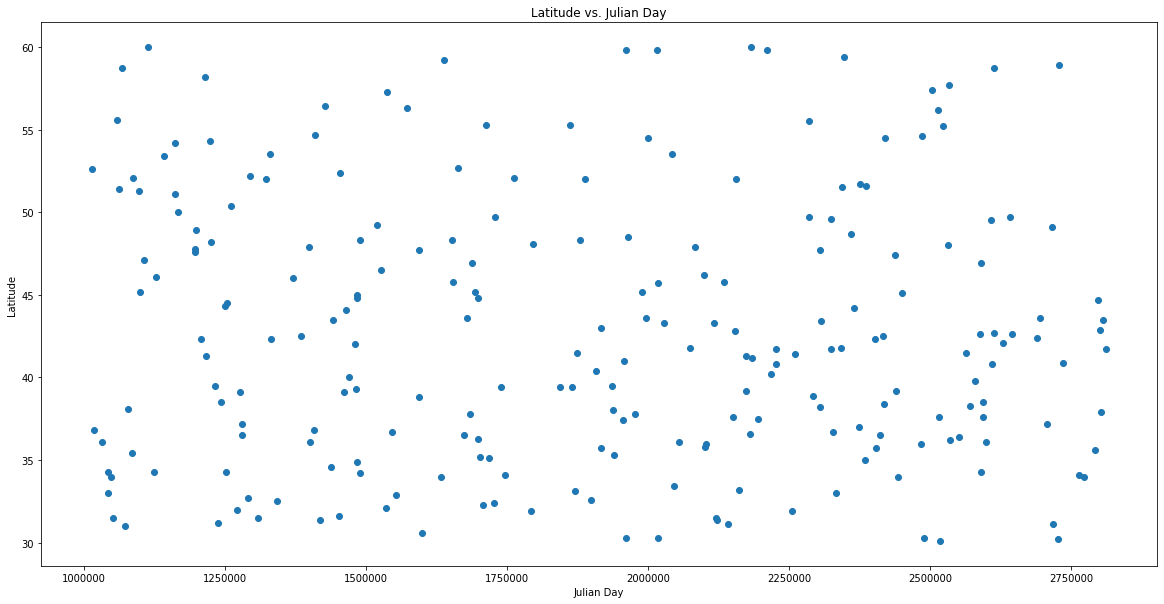

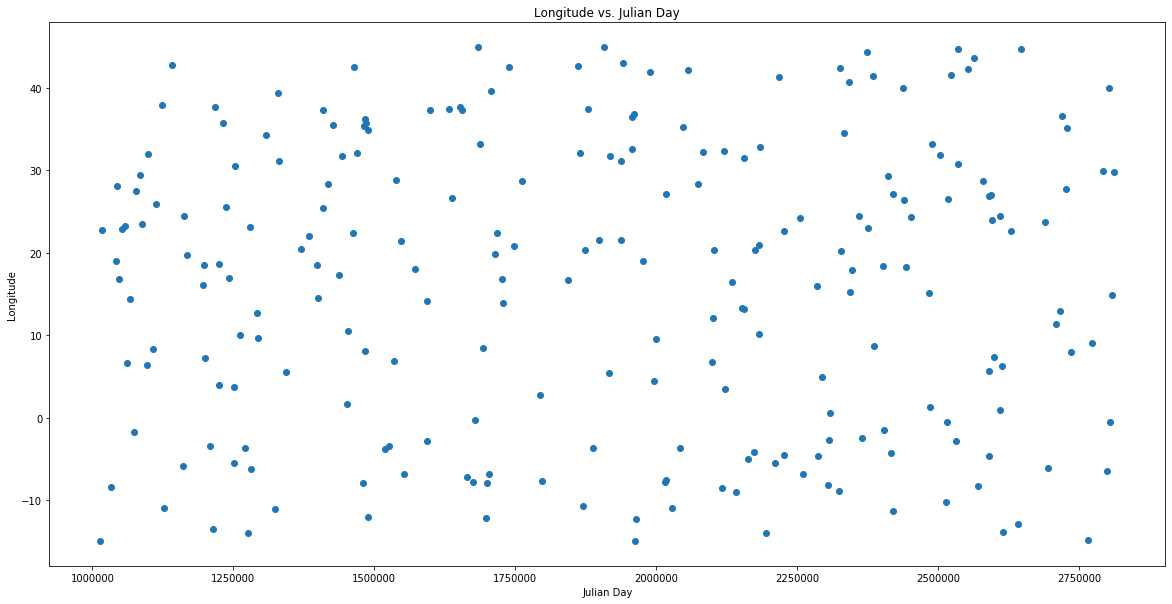

In [9]:
plot_locations(window)

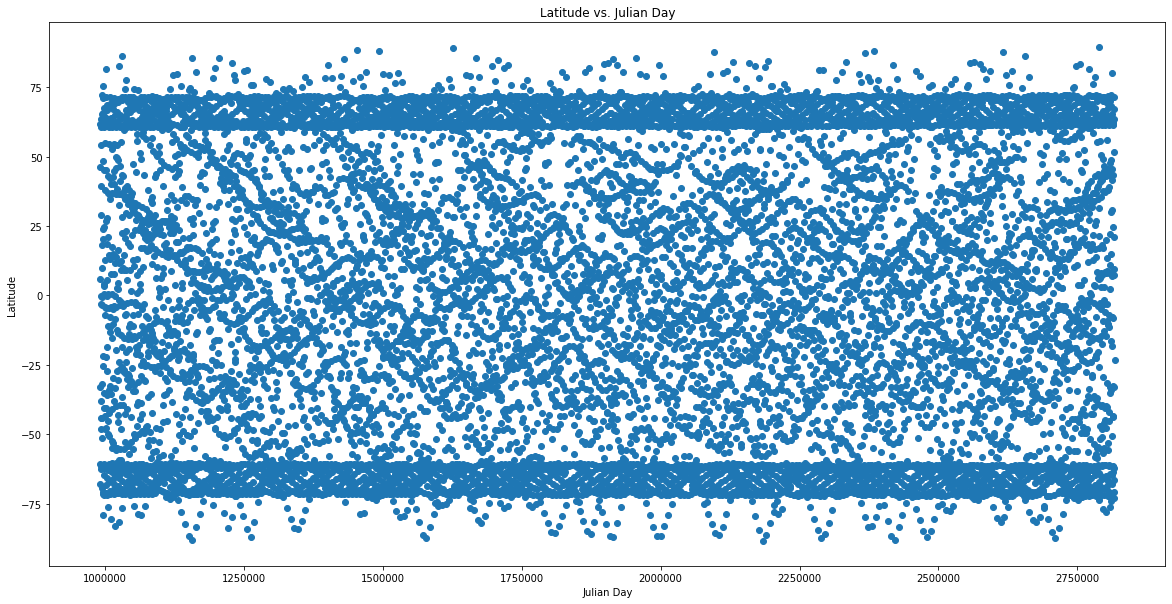

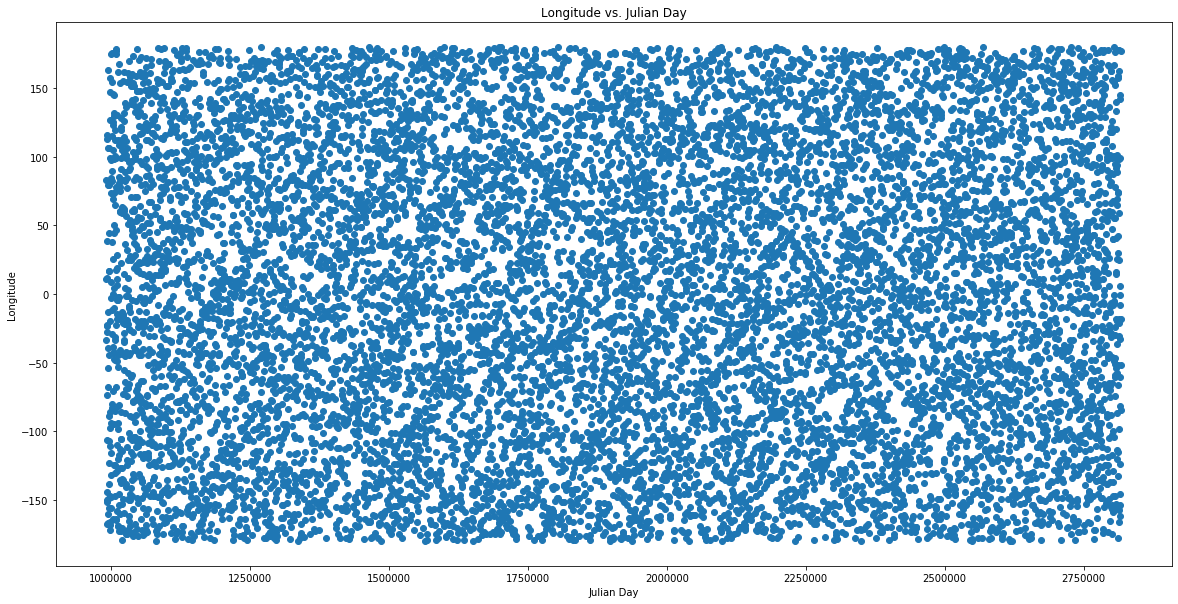

In [10]:
plot_locations(data)

In [11]:
def plot_saros(data, n):
    saros = data[data['Saros Number'] == n]
    dates = saros['Calendar Date'].str.split().apply(lambda x: int(x[0]))

    plt.xlabel('Year')
    plt.ylabel('Latitude')
    plt.title('Latitude vs. Year, Saros %d' % n)
    plt.scatter(dates, saros['Latitude'])
    plt.show()

    plt.xlabel('Year')
    plt.ylabel('Longitude')
    plt.title('Longitude vs. Year, Saros %d' % n)
    plt.scatter(dates, saros['Longitude'])

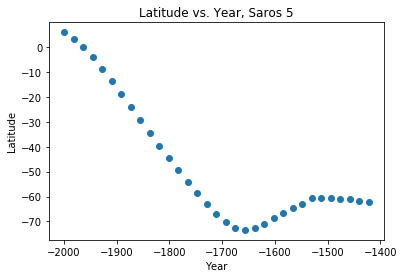

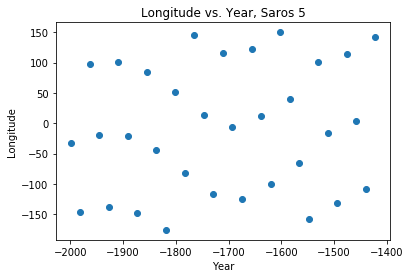

In [12]:
plot_saros(data, 5)

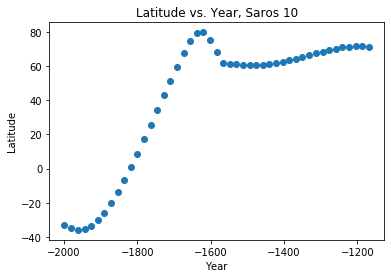

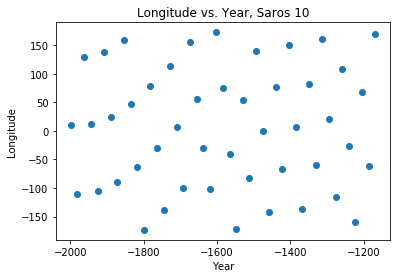

In [13]:
plot_saros(data, 10)

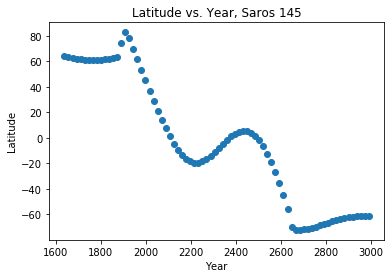

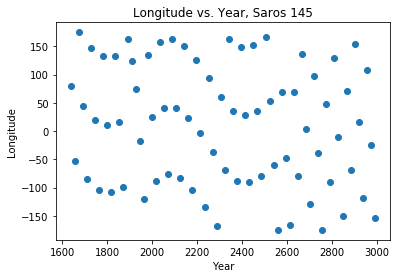

In [14]:
plot_saros(data, 145)

In [17]:
GENERATE_DATA = False # set GENERATE_DATA to True to generate data again. May take ~1h or more depending on processing power

In [29]:
def to_isoformat(date):
    date = date.split()
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    months = dict(zip(months, range(1, 13)))
    return '%s-%d-%s' % (date[0], months[date[1]], date[2])
        

In [30]:
if GENERATE_DATA:
    data = pd.read_csv('solar_eclipse_data.csv')

    # Select for years between 1900AD and 2100AD (to maintain accuracy of astropy data)
    # years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 1900 and int(x) <= 2050)
    # Select for years >= 0
    years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 0)
    data = data[years_to_keep]

    # Convert to ISO dates
    data['ISO Date'] = data['Calendar Date'] + ' ' + data['Eclipse Time']
    data['ISO Date'] = data['ISO Date'].apply(lambda x: to_isoformat(x))
    data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))
    data.head()

In [31]:
# All of the celestial bodies to generate synthetic data for
BODY_NAMES = ['moon', 'sun']

# Location is the Medicina Radio Observatory, located in Italy. Chosen for proximity to Greece
LOCATION = EarthLocation.of_site('medicina')

In [32]:
def get_coordinates(body):
    # Takes a Skycoord object, returns (theta, phi) in (deg, deg)
    angles = [float(i) for i in body.to_string().split(' ')]
    
    phi = angles[0]
    theta = angles[1]
    return phi, theta

def get_coordinate_rows(times):
    rows = defaultdict(list)
    for time in times:
        print(time)
        bodies = []

        with solar_system_ephemeris.set('builtin'):
            for body_name in BODY_NAMES:
                bodies.append(get_body(body_name, time, LOCATION))

        rows['time'].append(time)
        rows['location'].append(str(LOCATION))

        for body_name, body in zip(BODY_NAMES, bodies):
            theta, phi = get_coordinates(body)
            ecliptic = SkyCoord(theta, phi, frame='gcrs', unit=('deg', 'deg')).transform_to(GeocentricTrueEcliptic())
            coordinates = get_coordinates(ecliptic)
            coord_strings = ['theta', 'phi']

            for i in range(len(coord_strings)):
                c = coordinates[i]
                rows[body_name + '_' + coord_strings[i]].append(c)
    return rows

In [33]:
if GENERATE_DATA:
    times = data['ISO Date']
    rows = get_coordinate_rows(times)
    for k in rows.keys():
        data[k] = rows[k]

    data['latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
    data['longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))
    data = data[['ISO Date', 'longitude', 'latitude', 'moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
    data['eclipse'] = 1
    data.to_csv('solar_eclipse_pos_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [34]:
if GENERATE_DATA:
    # Generate the negative samples, i.e. times at which an eclipse is not occuring
    times = []
    for i in range(1, len(data)):
        # Difference in days
        days_difference = data['ISO Date'][i] - data['ISO Date'][i - 1]
        offset = 1
        # Enforce that datapoints in the non-eclipse class are sufficiently distant from datapoints in the eclipse class
        while offset < days_difference - 1:
            offset += abs(np.random.normal(5, 2))
            time = data['ISO Date'][i - 1] + offset
            times.append(time)

    rows = get_coordinate_rows(times)

    negative_data = pd.DataFrame(rows)
    negative_data['eclipse'] = 0
    negative_data.rename(columns={'time':'ISO Date'}, inplace=True)
    negative_data = negative_data.drop(columns='location')
    negative_data.to_csv('solar_eclipse_neg_data.csv', index=False)
else:
    negative_data = pd.read_csv('solar_eclipse_neg_data.csv')
negative_data['ISO Date'] = negative_data['ISO Date'].apply(lambda x: Time(x))

In [35]:
if GENERATE_DATA:
    data = data.drop(columns=['longitude', 'latitude']) # Drop the longitude and latitude from the positive dataset, as they are undefined for the negative dataset
    data = pd.concat([data, negative_data], sort=True)
    data.to_csv('solar_eclipse_final_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_final_data.csv')
data = data.sort_values('ISO Date')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [43]:
# Plot to understand the data
def plot_parameter(param, n):
    with warnings.catch_warnings(): # Ignore warnings about dubious date for astropy, and pandas future multi-indexing warning
        warnings.simplefilter("ignore")
        positive = data[data['eclipse'] == 1]
        negative = data[data['eclipse'] == 0]

        fig, ax = plt.subplots()
        dates = [pd.to_datetime(d.value.split('T')[0]) for d in positive['ISO Date'][:n]]
        pos = plt.plot_date(dates, positive[param][:n], label='eclipse=1')
        dates = [pd.to_datetime(d.value.split('T')[0]) for d in negative['ISO Date'][:n]]
        neg = plt.plot_date(dates, negative[param][:n], label='eclipse=0')
        date_form = DateFormatter("%Y-%m-%d")
        ax.set_title('%s vs. date' % param)
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=120))
        plt.legend()
        plt.show()

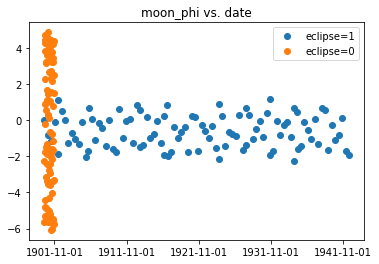

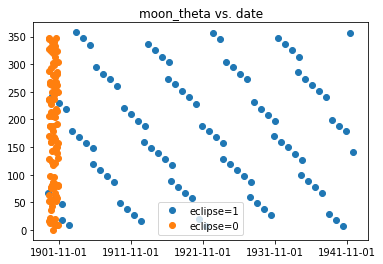

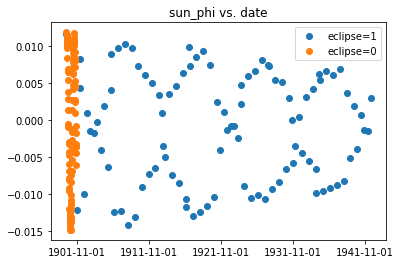

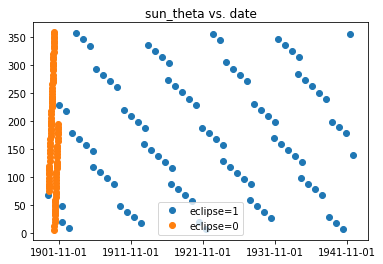

In [45]:
plot_parameter('moon_phi', 100)
plot_parameter('moon_theta', 100)
plot_parameter('sun_phi', 100)
plot_parameter('sun_theta', 100)

## Eclipse Incidence Prediction

This code handles model initialization, training and prediction to answer: "given a time and the position of the moon and sun, is an eclipse occuring?"

In [46]:
X = np.array(data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']])
X = np.append(X, [[d.jd] for d in data['ISO Date']], axis=1)
y = np.array(data['eclipse'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [KNeighborsClassifier(3),
    SVC(kernel="sigmoid", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


classifiers = dict(zip(names, classifiers))

In [64]:
print('Selecting best classifier by test score')
best_clf = (None, None)
for name, clf in classifiers.items():
    print('Training %s classifier' % name)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    if test_score >= best_test_score: # Select top-performing classifier by test score
        best_clf = (name, clf)
print('\nBest classifier by test score:', best_clf[0])
print('Train score:', best_clf[1].score(X_train, y_train))
print('Test score:', best_clf[1].score(X_test, y_test))

Selecting best classifier by test score
Training Nearest Neighbors classifier
Training Linear SVM classifier
Training RBF SVM classifier
Training Decision Tree classifier
Training Random Forest classifier
Training Neural Net classifier
Training AdaBoost classifier
Training Naive Bayes classifier
Training QDA classifier

Best classifier by test score: QDA
Train score: 0.9979171234378426
Test score: 0.9991231915826392


Confusion matrix (non-normalized)


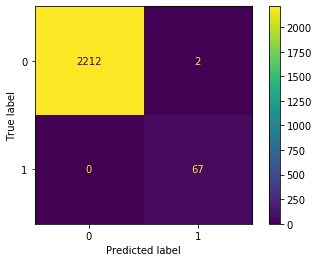

In [53]:
print('Confusion matrix (non-normalized)')
plot_confusion_matrix(best_clf[1], X_test, y_test)
plt.show()

Confusion matrix (normalized across predictions)


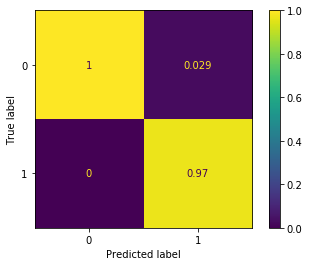

In [54]:
print('Confusion matrix (normalized across predictions)')
plot_confusion_matrix(best_clf[1], X_test, y_test, normalize='pred')
plt.show()

In [56]:
from sklearn.model_selection import GridSearchCV

Start grid search cross-validation on QDA classifier
Train score: 0.9979171234378426
Test score: 0.9991231915826392
Best reguliarization parameter: 1e-06


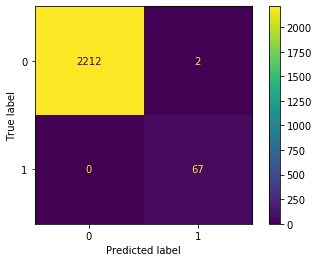

In [63]:
print('Grid search cross-validation on QDA classifier')
params = [{'reg_param': np.arange(0, 0.00001, 0.000001)}]
qda = QuadraticDiscriminantAnalysis()
clf = GridSearchCV(qda, params)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))
print('Best reguliarization parameter:', clf.best_params_['reg_param'])

## Eclipse Location Prediction

This code handles model initialization, training and prediction to answer: "given a time that an eclipse is occuring, the position of the moon, the position of the sun, where on Earth is the eclipse visible?"

Still work in progress!

In [104]:
data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

X = data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
X = pd.concat([X, pd.DataFrame([[d.jd] for d in data['ISO Date']])], axis=1)
y = data[['latitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [121]:
def test_regressor(reg, X_train, X_test, y_train, y_test):
    reg.fit(X_train, y_train)
    
    print('Training score:', reg.score(X_train, y_train))
    plt.scatter(y_train, reg.predict(X_train))
    plt.title('Predicted values vs. true values, training data')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.show()

    print('Test score:', reg.score(X_test, y_test))
    plt.scatter(y_test, reg.predict(X_test))
    plt.title('Predicted values vs. true values, training data')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.show()

Training score: 0.9065596525271711


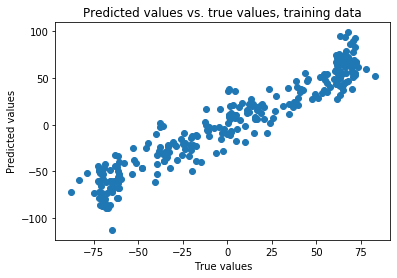

Test score: 0.9096326552197074


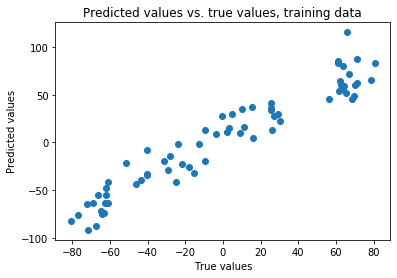

In [122]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_aug = poly.fit_transform(X_train)
X_test_aug = poly.fit_transform(X_test)
test_regressor(LinearRegression(), X_train_aug, X_test_aug, y_train, y_test)



Training score: 0.989755588332709


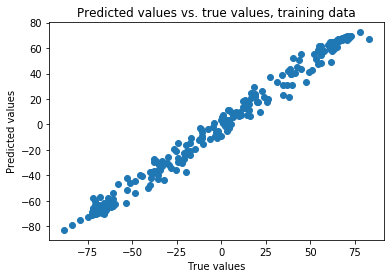

Test score: 0.8854513443973268


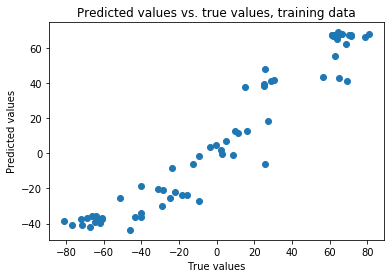

In [133]:
test_regressor(RandomForestRegressor(n_estimators=50), X_train, X_test, np.array(y_train).ravel(), np.array(y_test).ravel())

Training score: 0.8881713861181004


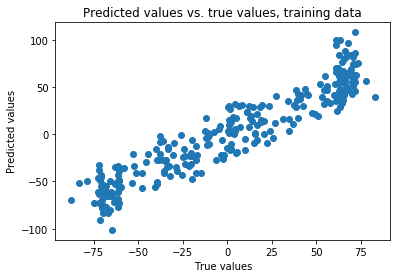

Test score: 0.9059183958593989


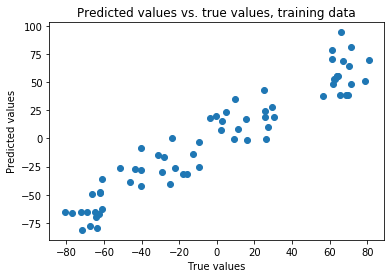

In [134]:
from sklearn.linear_model import RidgeCV, LinearRegression, Lasso, SGDRegressor
reg = RidgeCV(alphas=np.arange(0.1,100,0.1), fit_intercept=True)
test_regressor(reg, X_train, X_test, y_train, y_test)